# Characterizing the Hypergraph-of-Entity Representation Model

This representation model uses a weighted mixed hypergraph. Dependending on the version, the weights can be unitary constants. All versions combine directed and undirected hyperedges.

Possible node classes include:

- TermNode
- EntityNode

Possible hyperedge classes include:

- DocumentEdge
- ContainedInEdge
- RelatedToEdge
- SynonymEdge
- ContextEdge

In order to run the notebook, you must first obtain the corresponding CSV files through the `inspect` command in Army ANT. For example:

```bash
./army-ant.py inspect \
    --index-location=/opt/army-ant/indexes/inex-2009-3t-nl/hgoe \
    --index-type=hgoe \
    --workdir=/opt/army-ant/analysis/inex_2009_3t_nl-degree \
    --feature=export-node-degrees
```

You must then put the resulting files into the `data` directory for the collection and index version. For example `data/inex_2009_3t_nl/base_model` for the Hypergraph-of-Entity Base Model over the INEX 2009 3T-NL subset test collection. You should then configure the `base_dir` below accordingly. Bash scripts are provided in directory `runs/inex-2009-3t-nl/hgoe/nb-characterization`, in order to generate the required files.

In [47]:
if (!require("pacman")) install.packages("pacman")

pacman::p_load(
    logging,
    ggplot2,
    scales,
    repr,
    stringr,
    dplyr
)

basicConfig()
options(warn=-1)

base_dir <- "data/inex_2009_3t_nl/base_model"

We define a degree plotting function that takes the raw CSV, calculates the degree frequency and displays a point plot with a facet for each node or hyperedge type.

In [8]:
plot_degree_per_type <- function(data, label) {
    data <- split(data, data$type)
    data <- lapply(data, function(d) {
      cbind(
          type=d$type[1],
          setNames(as.data.frame(table(d$degree)), c("degree", "freq")))
    })
    data <- do.call(rbind, data)
    data$degree <- as.numeric(as.character(data$degree))

    ggplot(data, aes(x=degree, y=freq)) +
        facet_wrap(~type) +
        geom_point(size=0.5) +
        #stat_smooth(method = "lm") +
        scale_x_log10() + 
        scale_y_log10(limits=c(1,max(data$Freq))) +
        xlab(label) +
        ylab("Frequency")
}

We define a degree data loading function for a given `base_dir`, beautifying the node and hyperedge type labels (i.e., transforming from the Java class identifier to the node or hyperedge label used in the theory).

In [9]:
load_node_degree_data <- function(base_dir) {
    nodes_path <- paste(base_dir, list.files(path = base_dir, pattern = "node-degree-.*\\.csv"), sep="/")

    nodes <- setNames(read.csv(nodes_path, stringsAsFactors = F), c("node_id", "type", "degree"))
    
    nodes[which(nodes$type == "EntityNode"), "type"] <- "entity"
    nodes[which(nodes$type == "TermNode"), "type"] <- "term"
 
    nodes
}

load_edge_degree_data <- function(base_dir) {
    edges_path <- paste(base_dir, list.files(path = base_dir, pattern = "edge-degree-.*\\.csv"), sep="/")

    edges <- setNames(read.csv(edges_path, stringsAsFactors = F), c("edge_id", "type", "degree"))
    
    edges[which(edges$type == "DocumentEdge"), "type"] <- "document"
    edges[which(edges$type == "ContainedInEdge"), "type"] <- "contained_in"
    edges[which(edges$type == "RelatedToEdge"), "type"] <- "related_to"
    edges[which(edges$type == "SynonymEdge"), "type"] <- "synonym"
    edges[which(edges$type == "ContextEdge"), "type"] <- "context"
 
    edges
}

## Degree distributions

A hypergraph has two degree distributions, one for the nodes and another one for the hyperedges. We look at both.

In [10]:
node_degree <- load_node_degree_data(paste(base_dir, "global", sep="/"))
edge_degree <- load_edge_degree_data(paste(base_dir, "global", sep="/"))

In [11]:
head(node_degree)
head(edge_degree)

node_id,type,degree
0,entity,13778
1,entity,16299
2,entity,901
3,entity,7457
4,entity,45467
5,entity,16218


edge_id,type,degree
0,document,125
1,document,169
2,document,2
3,document,175
4,related_to,253
5,related_to,167


As we can see, the node degree distribution in the hypergraph-of-entity does not follow a power law, despite having a long tail.

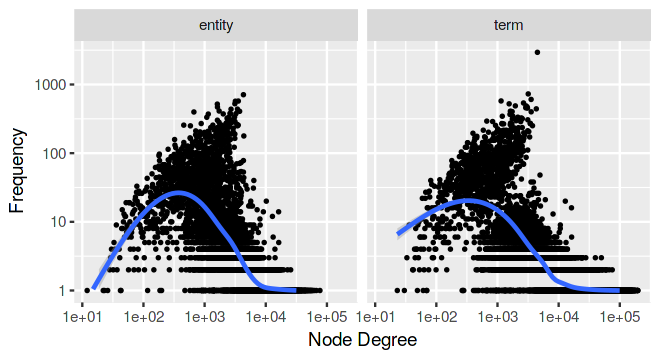

In [12]:
options(repr.plot.width=5.5, repr.plot.height=3)
plot_degree_per_type(node_degree, "Node Degree") + stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

On the other hand, the hyperedge degree distributions all follow power laws, with the `contained_in` hyperedges having less nodes than `document` or `related_to` hyperedges. This is expected, as `contained_in` hyperedges usually link a few `term` nodes to its corresponding `entity` node.

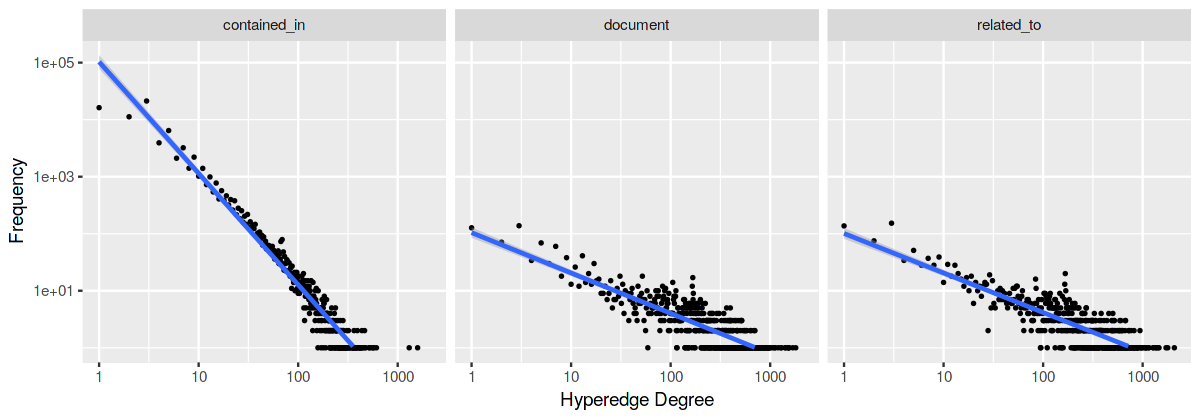

In [13]:
options(repr.plot.width=10, repr.plot.height=3.5)
plot_degree_per_type(edge_degree, "Hyperedge Degree") + stat_smooth(method="lm")

## Global statistics

## Scalability

In order to better understand the impact of adding more documents and entities to the index, we created several snapshots by limiting the number of documents read from INEX 2009 3T-NL subset test collection. We then obtained the following aggregated statistics from each snapshot studying their evolution for an increasing number of documents:

- Average node degree
 - Average node indegree
 - Average node outdegree
- Average hyperedge degree
 - Average degree for undirected hyperedges
 - Average overall, tail and head degrees for directed hyperedges
- Estimated two-node clustering coefficient
- Estimated average path length and diameter
- General mixed hypergraph density
- Size
 - Number of nodes and hyperedges
 - Number of bytes

We will begin by the node and hyperedge degree. In order to generate the required data, run the scripts in `runs/inex-2009-3t-nl/hgoe/scalability` in order. This will generate indices with a progressively larger number of documents, using the `--limit` argument (snapshots). Inspect will then generate the node and edge degree distributions per index snapshot, properly organizing them in a directory with name `snapshot_<id>_<num_docs>`.

In [96]:
load_snapshots_degree_data <- function(base_dir, type="node") {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- paste(base_dir, snapshot, sep="/")
        path <- paste(base_dir, snapshot, sep="/")

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call(paste("load", type, "degree_data", sep="_"), list(base_dir = path)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    setNames(data, c(names(data)[1:3], "node_id", "type", "degree"))
}

In [97]:
snapshot_node_degree <- load_snapshots_degree_data(paste(base_dir, "snapshots", sep="/"), type="node")
snapshot_edge_degree <- load_snapshots_degree_data(paste(base_dir, "snapshots", sep="/"), type="edge")

In [98]:
head(snapshot_node_degree)
head(snapshot_edge_degree)

snapshot_name,snapshot_id,num_docs,node_id,type,degree
snapshot_001_1,001,1,0,entity,257
snapshot_001_1,001,1,1,entity,257
snapshot_001_1,001,1,2,entity,257
snapshot_001_1,001,1,3,entity,257
snapshot_001_1,001,1,4,entity,257
snapshot_001_1,001,1,5,entity,257


snapshot_name,snapshot_id,num_docs,node_id,type,degree
snapshot_001_1,001,1,0,document,3
snapshot_001_1,001,1,1,related_to,3
snapshot_001_1,001,1,2,contained_in,3
snapshot_001_1,001,1,3,contained_in,2
snapshot_001_1,001,1,4,contained_in,2
snapshot_001_1,001,1,5,contained_in,3


In [115]:
plot_degree_over_time <- function(data, label) {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(mean=mean(degree, na.rm=TRUE), se=sd(degree)/sqrt(length(degree)))

    ggplot(data, aes(x=num_docs, y=mean)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}
                      
plot_size_over_time <- function(data, label) {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(len=length(degree), se=sd(degree)/sqrt(length(degree)))

    ggplot(data, aes(x=num_docs, y=len)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

### Average degree

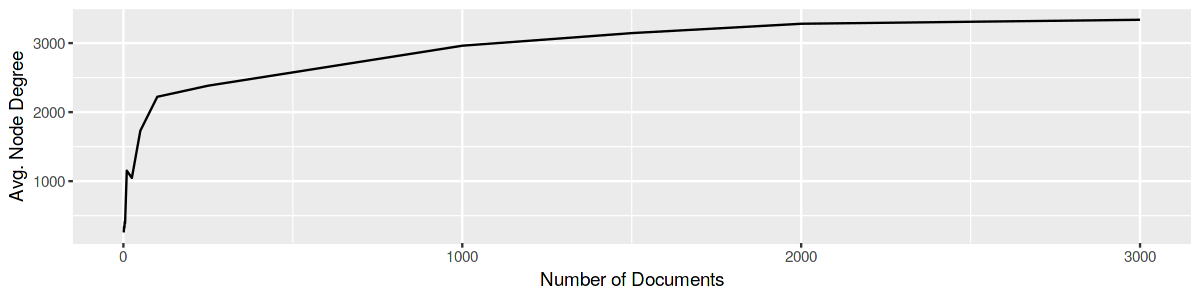

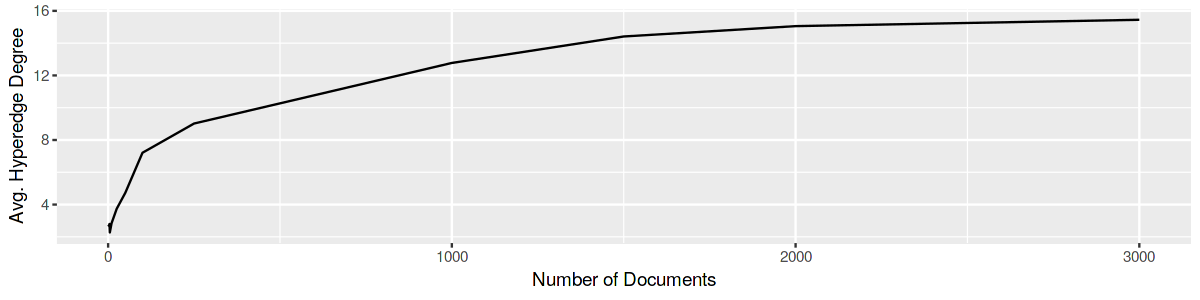

In [116]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(snapshot_node_degree, "Avg. Node Degree")
plot_degree_over_time(snapshot_edge_degree, "Avg. Hyperedge Degree")

#### Average node indegree

#### Average node outdegree

#### Average degree for undirected hyperedges

#### Average overall, tail and head degrees for directed hyperedges

### Estimated two-node clustering coefficient

### Estimated average path length and diameter

### General mixed hypergraph density

### Size

#### Number of nodes and hyperedges

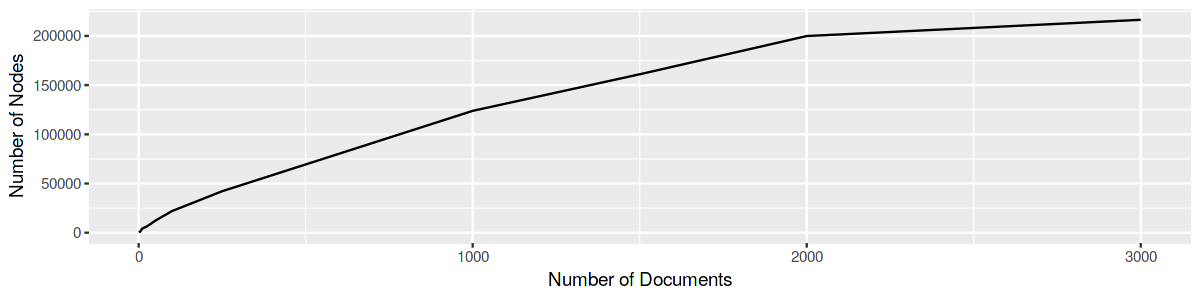

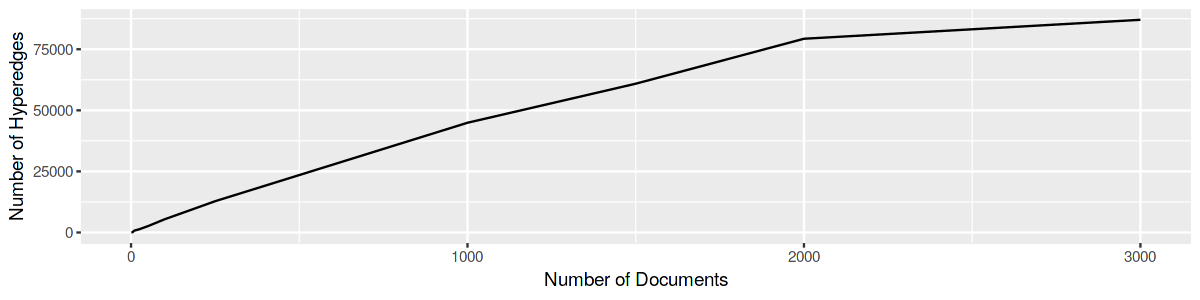

In [117]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_size_over_time(snapshot_node_degree, "Number of Nodes")
plot_size_over_time(snapshot_edge_degree, "Number of Hyperedges")

#### Number of bytes